# FastICA implementation

## 0. Environment setup

In [1]:
%load_ext autoreload
%autoreload 2

import logging

import numpy as np

from fast_ica import FastICA
from utils import sine_wave, square_wave, sawtooth_wave, plot_signal

logging.basicConfig(level=logging.INFO)

SIG_LEN = 16  # s
SIG_FS = 2048  # Hz
SNR = 20  # dB
SEED = 42

## 1. Signal creation
In this section we create the original signals (3 components):

- a sinusoidal wave;
- a square wave;
- a sawtooth wave.

In particular, we will have 3 components made up by 1000 samples each.

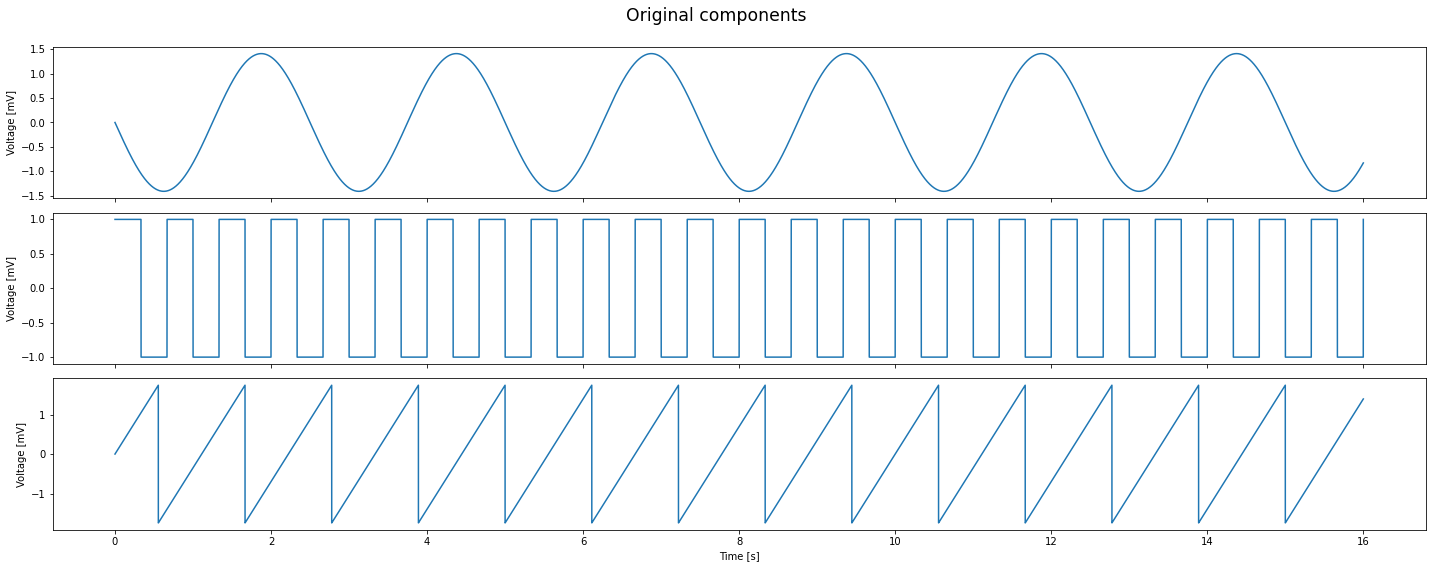

In [2]:
t = np.linspace(0, SIG_LEN, SIG_LEN * SIG_FS)

# Matrix S with the original signals (n_components, n_samples)
S = np.vstack([
    sine_wave(t, amp=1.5, freq=0.4, phase=np.pi),
    square_wave(t, amp=1, freq=1.5, phase=0),
    sawtooth_wave(t, amp=0.5, freq=0.9, phase=-np.pi)
])
# Make std unitary
std = S.std(axis=1)
S = (S.T / std).T
n_components, n_samples = S.shape

plot_signal(S, fs=SIG_FS, title="Original components", fig_size=(20, 8))

Then, we generate the random mixing matrix A: we multiply it by S to obtain the observations X, namely the mixed signals.

[[ 1.22179449 -4.94997299 -2.95182992]
 [ 0.15779742  0.28656666  1.00984642]
 [-0.26659516 -2.98187861  3.97515268]
 [ 0.814014   -1.24982651  0.52194753]]


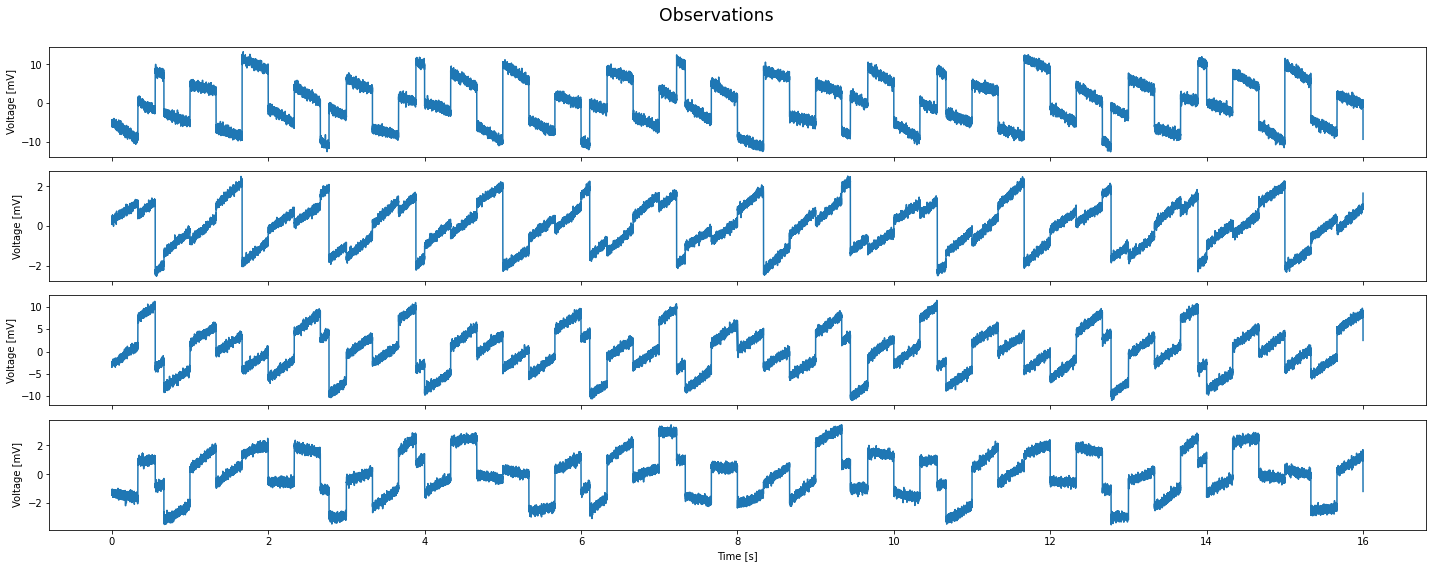

In [3]:
# Mixing matrix A
A = np.random.normal(scale=2.5, size=(4, 3))
print(A)

# Observations X (n_channels, n_samples)
X = np.matmul(A, S)
n_channels, _ = X.shape

# Compute signal power and convert to dB
X_avg_power = np.mean(np.square(X), axis=1)
X_avg_db = 10 * np.log10(X_avg_power)
# Compute noise power
noise_avg_db = X_avg_db - SNR
noise_avg_power = 10 ** (noise_avg_db / 10)

# Generate white Gaussian noise with given power
noise = np.zeros_like(X)
for i in range(n_channels):  # iterate over channels
    noise[i] = np.random.standard_normal(n_samples)
    scale = np.sqrt(noise_avg_power[i]) / noise[i].std()
    noise[i] *= scale
X += noise

plot_signal(X, fs=SIG_FS, title="Observations", fig_size=(20, 8))

## 2. FastICA
Through the FastICA algorithm, implemented in the `FastICA` class imported before, we estimate W, the inverse of the mixing matrix, and then S (by multiplying W with the observations).
The observations must be preprocessed by centering and whitening (already implemented in the function).

INFO:root:Deflation strategy
INFO:root:----- SOURCE 1 -----
INFO:root:Initialization done using index 11976 with value 1.052e+01.
INFO:root:FastICA converged after 5 iterations, the distance is: 4.483e-10.
INFO:root:----- SOURCE 2 -----
INFO:root:Initialization done using index 21234 with value 6.779e+00.
INFO:root:FastICA converged after 5 iterations, the distance is: 6.023e-05.
INFO:root:----- SOURCE 3 -----
INFO:root:Initialization done using index 22138 with value 7.089e+00.
INFO:root:FastICA converged after 3 iterations, the distance is: 5.502e-06.


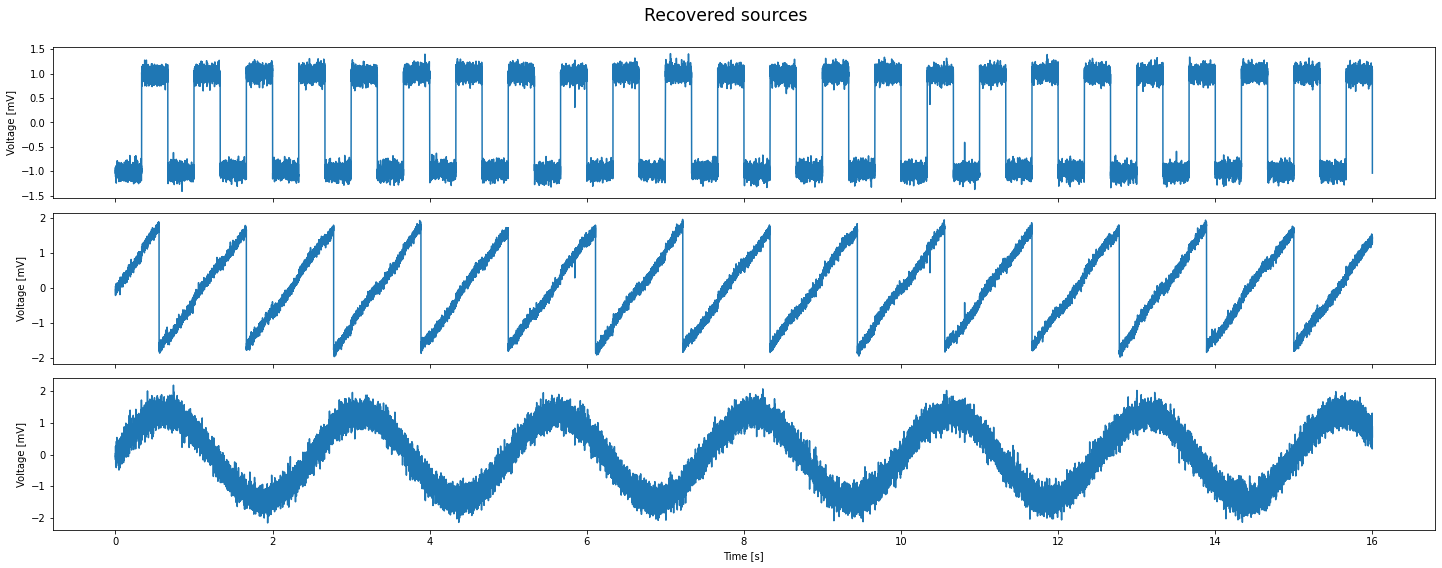

In [4]:
fast_ica = FastICA(n_comp=3, fs=SIG_FS, strategy="deflation", seed=SEED)
my_S = fast_ica.calibrate(X)

plot_signal(my_S, fs=SIG_FS, title="Recovered sources", fig_size=(20, 8))

## 3. Deflation vs parallel
In the `fast_ica` implementation, there are two strategies:

- deflation, which computes each unit sequentially and accumulates the error;
- parallel, which computes each unit in parallel and averages the error.

Let's compare them.

INFO:root:Deflation strategy
INFO:root:----- SOURCE 1 -----
INFO:root:Initialization done using index 11976 with value 1.052e+01.
INFO:root:FastICA converged after 5 iterations, the distance is: 4.483e-10.
INFO:root:----- SOURCE 2 -----
INFO:root:Initialization done using index 21234 with value 6.779e+00.
INFO:root:FastICA converged after 5 iterations, the distance is: 6.023e-05.
INFO:root:----- SOURCE 3 -----
INFO:root:Initialization done using index 22138 with value 7.089e+00.
INFO:root:FastICA converged after 3 iterations, the distance is: 5.502e-06.


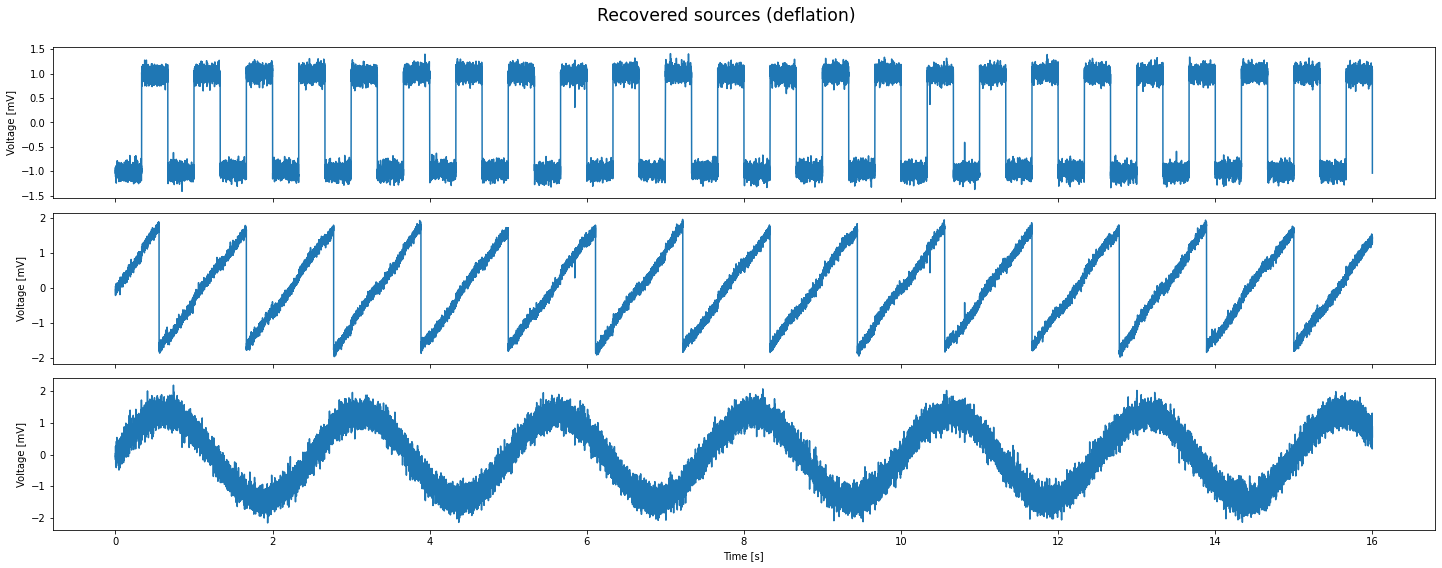

In [5]:
fast_ica = FastICA(n_comp=3, fs=SIG_FS, strategy="deflation", seed=SEED)
my_S = fast_ica.calibrate(X)

plot_signal(my_S, fs=SIG_FS, title="Recovered sources (deflation)", fig_size=(20, 8))

INFO:root:Parallel strategy
INFO:root:FastICA converged after 4 iterations, the distance is: 5.524e-05.


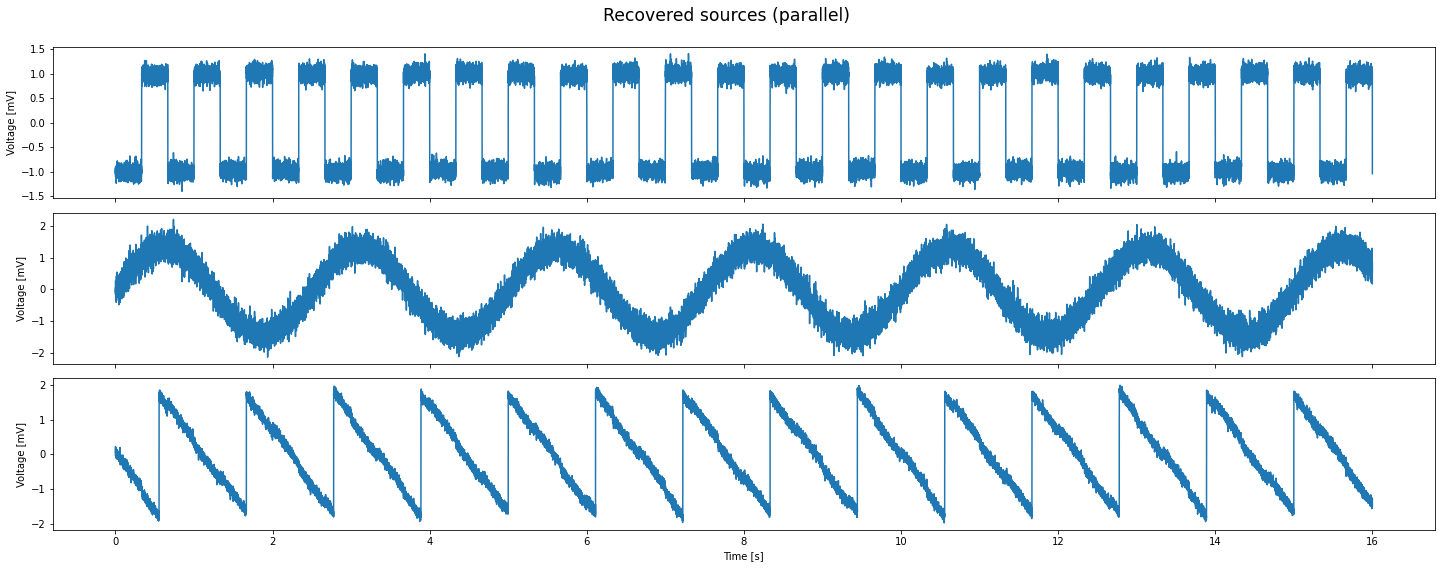

In [6]:
fast_ica = FastICA(n_comp=3, fs=SIG_FS, strategy="parallel", seed=SEED)
my_S = fast_ica.calibrate(X, approx=False)

plot_signal(my_S, fs=SIG_FS, title="Recovered sources (parallel)", fig_size=(20, 8))

As it can be seen, the parallel strategy enables faster convergence. However, the symmetric de-correlation used in the parallel strategy is computationally expensive. Thus, we will test an approximated version.

INFO:root:Parallel strategy
INFO:root:Symmetric de-correlation approximation converged after 6 iterations with distance = 4.075e-08
INFO:root:Symmetric de-correlation approximation converged after 10 iterations with distance = 3.755e-05
INFO:root:Symmetric de-correlation approximation converged after 6 iterations with distance = 3.653e-06
INFO:root:Symmetric de-correlation approximation converged after 5 iterations with distance = 2.154e-05
INFO:root:Symmetric de-correlation approximation converged after 5 iterations with distance = 1.500e-05
INFO:root:FastICA converged after 4 iterations, the distance is: 7.346e-05.


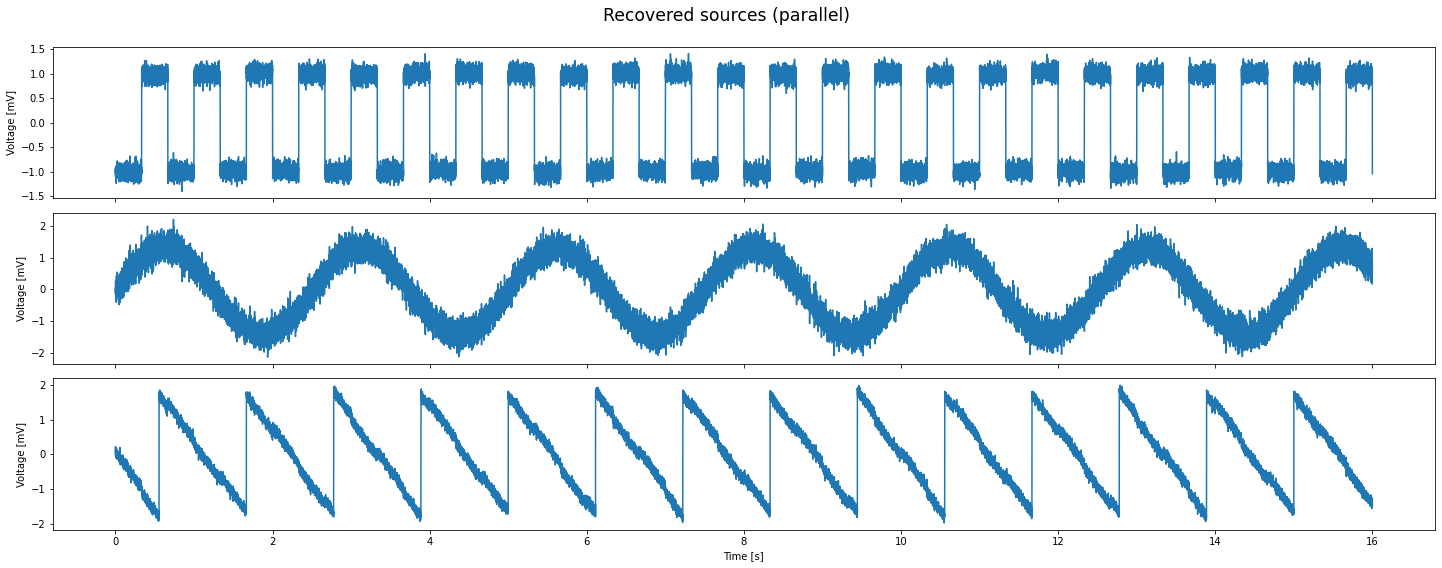

In [7]:
fast_ica = FastICA(n_comp=3, fs=SIG_FS, strategy="parallel", seed=SEED)
my_S = fast_ica.calibrate(X, approx=True)

plot_signal(my_S, fs=SIG_FS, title="Recovered sources (parallel)", fig_size=(20, 8))